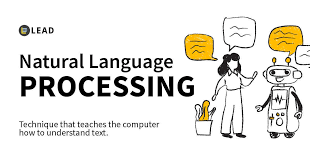

<h1>S12 T01: Pipelines, grid search and text mining</h1>

<h2>Libraries</h2>

In [95]:
#Python library 
import requests
from urllib.request import urlopen
import string


#Data Manipulation
import pandas as pd 
import numpy as np
from geopandas import read_file
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imbPipeline  
from imblearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import (train_test_split, 
                                      StratifiedKFold, 
                                    GridSearchCV)
from sklearn.metrics import (classification_report, 
                             multilabel_confusion_matrix)

#Text 
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
 

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import folium
from sklearn import set_config
import scikitplot as skplt



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\debyf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\debyf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\debyf\AppData\Roaming\nltk_data...


<h2>Notebook Functions</h2>

In [384]:
#1: Percent of nan values
def percent_nan(df):
    return round((df.isnull().sum()/df.shape[0])*100,2) 

In [385]:
#2: group by df
def grouped_df(df,col):
    return df.groupby(col).sum()

In [386]:
#3: isolate a column
def isolate_col(df,col):
    return df[col]

In [387]:
#4 function to the data type to another
def astype_convertion(df,cols,dtype):
    df[cols] = df[cols].astype(dtype)

In [388]:
#5 filter by type of veh
def veh_type(df,col,veh): 
    return df.loc[df[col] ==  veh ]

In [389]:
#6 plot map with num of vehicles  
def plot_veh(df1,df2,col,label1 ,max_val ):
    fig, ax = plt.subplots(figsize=(12,12)) 
    
    df1.plot(col,
                  markersize = 1000 * df1[col]/df1[col].max()    ,
                  ax=ax,color="red")
    
    df2.plot('Nombre_vehicles',ax=ax, cmap="OrRd" , edgecolor='k', 
             alpha= .4,legend=True,legend_kwds=
             {'label': "Total Vehicles by district",
                        'orientation': "horizontal", 'shrink':.8, 'pad':.1}  )
    
    ax.set_title(col+" "+"by Districts")
    
    for x, y, labels1  in zip(df1.geometry.x,df1.geometry.y , df1[col] ):
        ax.annotate(labels1, xy=(x , y ), xytext=(3, 3), 
                    textcoords="offset points",
                    ha='center'
                   )
        
        
         
    plt.show()

In [390]:
#7 function to select dtype
def select_dtype(df,feat):
    return df.select_dtypes(include = feat).columns


In [391]:
#8 function to drop columns
def drop_cols(df,cols):
    return df.drop(columns=cols)

In [392]:
#9 function to plot the confusion matrix for each class (multiclass)
def plot_conf_matrix(matrix,title):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    group_counts = ["{0:0.0f}".format(v) for v in matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) 
                     for value in matrix.flatten()/np.sum(matrix)]
    labels = [f"{ant1}\n{ant2}" for ant1, ant2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(matrix, annot=labels, fmt='', 
                 cmap='Blues', ax=ax)
    ax.set_title(title) 
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

<h2>Level 1</h2>

 <h3>EDA</h3>

In [393]:
#url of the data for the exercise 
url = "https://opendata-ajuntament.barcelona.cat/data/dataset/90dc3d6e-1c9a-4136-aed8-74bebb43e052/resource/227e5ef8-7ada-44f9-bbbc-d167c0173889/download/2021_tipologia_parc_vehicles.csv"

In [394]:
#the data shows the type of vehicles by Barcelona district    
data = pd.read_csv(url) 
data

,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Seccio_censal,Tipologia_parc,Nombre_vehicles
0,2021,01,Ciutat Vella,01,el Raval,1,Turismes,338
1,2021,01,Ciutat Vella,01,el Raval,1,Motos,128
2,2021,01,Ciutat Vella,01,el Raval,1,Ciclomotors,682
3,2021,01,Ciutat Vella,01,el Raval,1,Furgonetes,51
4,2021,01,Ciutat Vella,01,el Raval,1,Camions,23
...,...,...,...,...,...,...,...,...
6399,2021,NC,No consta,NC,No consta,NC,Motos,101
6400,2021,NC,No consta,NC,No consta,NC,Ciclomotors,66
6401,2021,NC,No consta,NC,No consta,NC,Furgonetes,22
6402,2021,NC,No consta,NC,No consta,NC,Camions,9


In [395]:
#there are missing values but as a string 
No_Consta_Data = data.loc[data['Codi_Barri'] ==  "NC" ]
No_Consta_Data

,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Seccio_censal,Tipologia_parc,Nombre_vehicles
6398,2021,NC,No consta,NC,No consta,NC,Turismes,192
6399,2021,NC,No consta,NC,No consta,NC,Motos,101
6400,2021,NC,No consta,NC,No consta,NC,Ciclomotors,66
6401,2021,NC,No consta,NC,No consta,NC,Furgonetes,22
6402,2021,NC,No consta,NC,No consta,NC,Camions,9
6403,2021,NC,No consta,NC,No consta,NC,Altres vehicles,4


In [396]:
df = data.copy()

In [397]:
#replace the string with a NaN
df.replace(['No consta',"NC"], np.nan,inplace=True) 

In [398]:
#% of the NaN value
percent_nan(df)

Any                0.00
Codi_Districte     0.09
Nom_Districte      0.09
Codi_Barri         0.09
Nom_Barri          0.09
Seccio_censal      0.09
Tipologia_parc     0.00
Nombre_vehicles    0.00
dtype: float64

In [399]:
#the missing data is a small percent of the total data and I will drop it 
df.dropna(axis=0,inplace=True)

In [400]:
percent_nan(df)

Any                0.0
Codi_Districte     0.0
Nom_Districte      0.0
Codi_Barri         0.0
Nom_Barri          0.0
Seccio_censal      0.0
Tipologia_parc     0.0
Nombre_vehicles    0.0
dtype: float64

In [401]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6398 entries, 0 to 6397
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Any              6398 non-null   int64 
 1   Codi_Districte   6398 non-null   object
 2   Nom_Districte    6398 non-null   object
 3   Codi_Barri       6398 non-null   object
 4   Nom_Barri        6398 non-null   object
 5   Seccio_censal    6398 non-null   object
 6   Tipologia_parc   6398 non-null   object
 7   Nombre_vehicles  6398 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 449.9+ KB


In [402]:
#transform the feaures as categorical values
astype_convertion(df,["Nom_Districte","Nom_Barri","Tipologia_parc"],"category")

In [403]:
#this dataset is for mapping barcelona 
barcelona_shape = read_file("/Volumes/GoogleDrive/Mi unidad/Barcelona Activa/Itinerario Data Science/S12/shapefiles_barcelona_distrito/shapefiles_barcelona_distrito.shp"
                           ).set_index('c_distri').sort_index()
barcelona_shape.head()

,cartodb_id,n_distri,homes,dones,area,perim,coord_x,coord_y,web_1,web_2,web_3,geometry
c_distri,,,,,,,,,,,,
01,1,Ciutat Vella,53968,48379,4.368465e+06,21035.207261,431616.773990,4.581564e+06,http://www.bcn.cat/ciutatvella,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.18239 41.39143, 2.18346 41.39061, ..."
02,2,Eixample,123571,142906,7.476392e+06,13902.573980,430243.353657,4.582773e+06,http://www.bcn.cat/eixample,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.18239 41.39143, 2.18135 41.39222, ..."
03,3,Sants-MontjuÃ¯c,87877,95243,2.294042e+07,47125.925905,428562.773279,4.578163e+06,http://www.bcn.cat/sants-montjuic,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.16785 41.37498, 2.16856 41.37495, ..."
04,4,Les Corts,38331,43939,6.017532e+06,12481.472647,426369.646389,4.582295e+06,http://www.bcn.cat/lescorts,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.10291 41.40109, 2.10295 41.40110, ..."
05,5,SarriÃ -Sant Gervasi,67799,80113,2.009280e+07,37563.642237,425388.507986,4.585170e+06,http://www.bcn.cat/sarria-santgervasi,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"MULTIPOLYGON (((2.07212 41.41270, 2.07050 41.4..."


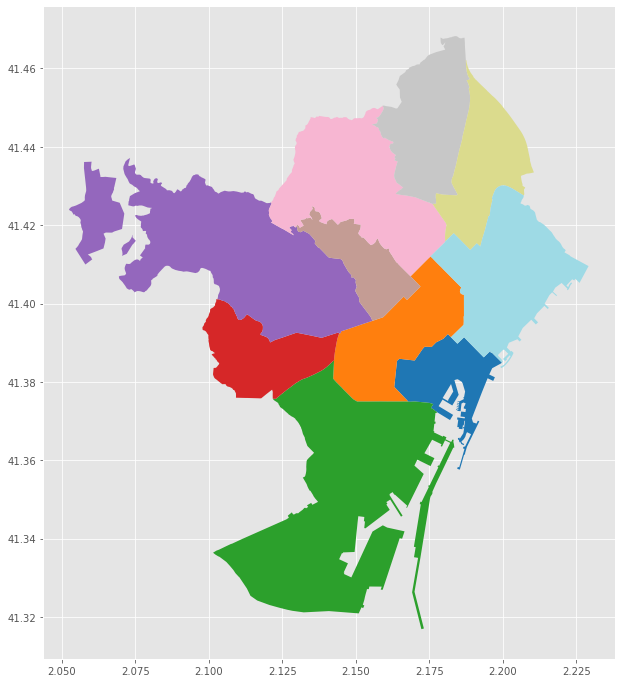

In [404]:
#map of barcelona by distric
fig, ax = plt.subplots(figsize=(12, 12))
barcelona_shape.plot('cartodb_id', cmap='tab20',ax=ax)
plt.show()

In [405]:
#use function (2 & 3) to create a pandas pipe for group and isolate the 
#veh by neighborhood  
veh_by_distric = df.pipe(grouped_df,col="Codi_Districte").pipe(isolate_col,col="Nombre_vehicles")
veh_by_distric

Codi_Districte
01     41530
02    136061
03     86682
04     50340
05    104854
06     59286
07     83433
08     69527
09     68245
10    111321
Name: Nombre_vehicles, dtype: int64

In [406]:
#rename the feature
df["Tipologia_parc"] = df.Tipologia_parc.cat.rename_categories({"Altres vehicles":"Altres Vehicles"},
                                    )

In [407]:
#make a list with the name categories   
veh_types = df.Tipologia_parc.cat.categories
veh_types

Index(['Altres Vehicles', 'Camions', 'Ciclomotors', 'Furgonetes', 'Motos',
       'Turismes'],
      dtype='object')

In [408]:
# find the number of vehicles by district

Altres_vehicles_by_district = df.pipe(veh_type,"Tipologia_parc","Altres Vehicles").pipe(grouped_df,"Codi_Districte").pipe(isolate_col,col="Nombre_vehicles").rename("Num_Altres_vehicles",inplace=True) 
Camions_by_district = df.pipe(veh_type,"Tipologia_parc","Camions").pipe(grouped_df,"Codi_Districte").pipe(isolate_col,col="Nombre_vehicles").rename("Num_Camions",inplace=True) 
Ciclomotors_by_district = df.pipe(veh_type,"Tipologia_parc","Ciclomotors").pipe(grouped_df,"Codi_Districte").pipe(isolate_col,col="Nombre_vehicles").rename("Num_Ciclomotors",inplace=True) 
Furgonetes_by_district = df.pipe(veh_type,"Tipologia_parc","Furgonetes").pipe(grouped_df,"Codi_Districte").pipe(isolate_col,col="Nombre_vehicles").rename("Num_Furgonetes",inplace=True) 
Motos_by_district = df.pipe(veh_type,"Tipologia_parc","Motos").pipe(grouped_df,"Codi_Districte").pipe(isolate_col,col="Nombre_vehicles").rename("Num_Motos",inplace=True) 
Turismes_by_district = df.pipe(veh_type,"Tipologia_parc","Turismes").pipe(grouped_df,"Codi_Districte").pipe(isolate_col,col="Nombre_vehicles").rename("Num_Turismes",inplace=True)    

In [409]:
#number of other vehicles by district 
Altres_vehicles_by_district

Codi_Districte
01     774
02    3996
03    4577
04     691
05    1343
06     763
07    1130
08    1006
09    1142
10    2135
Name: Num_Altres_vehicles, dtype: int64

In [410]:
#concat the data in the barcelona dataset
df_bcn_veh = pd.concat([barcelona_shape,
                        veh_by_distric,
                        Altres_vehicles_by_district,
                       Camions_by_district,
                       Ciclomotors_by_district,
                        Furgonetes_by_district,
                        Motos_by_district,
                        Turismes_by_district],axis=1)
df_bcn_veh 

,cartodb_id,n_distri,homes,dones,area,perim,coord_x,coord_y,web_1,web_2,web_3,geometry,Nombre_vehicles,Num_Altres_vehicles,Num_Camions,Num_Ciclomotors,Num_Furgonetes,Num_Motos,Num_Turismes
01,1,Ciutat Vella,53968,48379,4.368465e+06,21035.207261,431616.773990,4.581564e+06,http://www.bcn.cat/ciutatvella,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.18239 41.39143, 2.18346 41.39061, ...",41530,774,1343,7424,3201,11645,17143
02,2,Eixample,123571,142906,7.476392e+06,13902.573980,430243.353657,4.582773e+06,http://www.bcn.cat/eixample,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.18239 41.39143, 2.18135 41.39222, ...",136061,3996,2524,7987,6280,39201,76073
03,3,Sants-MontjuÃ¯c,87877,95243,2.294042e+07,47125.925905,428562.773279,4.578163e+06,http://www.bcn.cat/sants-montjuic,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.16785 41.37498, 2.16856 41.37495, ...",86682,4577,3157,5024,4759,20593,48572
04,4,Les Corts,38331,43939,6.017532e+06,12481.472647,426369.646389,4.582295e+06,http://www.bcn.cat/lescorts,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.10291 41.40109, 2.10295 41.40110, ...",50340,691,627,2395,1706,14069,30852
05,5,SarriÃ -Sant Gervasi,67799,80113,2.009280e+07,37563.642237,425388.507986,4.585170e+06,http://www.bcn.cat/sarria-santgervasi,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"MULTIPOLYGON (((2.07212 41.41270, 2.07050 41.4...",104854,1343,1038,4265,3175,36830,58203
06,6,GrÃ cia,55611,65891,4.185517e+06,12280.060880,429253.013001,4.584840e+06,http://www.bcn.cat/gracia,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.16865 41.40696, 2.16979 41.40608, ...",59286,763,702,3240,2332,19040,33209
07,7,Horta-GuinardÃ³,79017,89075,1.194708e+07,20413.187364,429117.618770,4.586950e+06,http://www.bcn.cat/horta-guinardo,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.17616 41.42544, 2.17654 41.42500, ...",83433,1130,1053,4555,3813,23726,49156
08,8,Nou Barris,78448,87862,8.041439e+06,14698.411907,431185.040621,4.588829e+06,http://www.bcn.cat/noubarris,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.18745 41.46213, 2.18744 41.46212, ...",69527,1006,1109,3720,3844,14850,44998
09,9,Sant Andreu,70151,77581,6.565322e+06,15132.450209,432697.846739,4.587572e+06,http://www.bcn.cat/santandreu,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.20719 41.42756, 2.20558 41.42831, ...",68245,1142,1282,2927,3534,15293,44067
10,10,Sant MartÃ­,113572,122147,1.052376e+07,20736.527911,433330.835564,4.584520e+06,http://www.bcn.cat/santmarti,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.20719 41.42756, 2.20715 41.42747, ...",111321,2135,1806,7738,5654,25308,68680


In [411]:
#get the centroids from the poligons of the districts  
centroids_bcn_veh_df =  df_bcn_veh["geometry"].centroid  
centroids_bcn_veh_df.rename("geometry",inplace=True)
 

/var/folders/sq/fggxzcn90p73_7hm62_tglm40000gn/T/ipykernel_1295/725556170.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_bcn_veh_df =  df_bcn_veh["geometry"].centroid


01    POINT (2.18105 41.38084)
02    POINT (2.16449 41.39162)
03    POINT (2.14493 41.34995)
04    POINT (2.11821 41.38697)
05    POINT (2.10612 41.41277)
06    POINT (2.15240 41.41015)
07    POINT (2.15053 41.42914)
08    POINT (2.17506 41.44624)
09    POINT (2.19331 41.43505)
10    POINT (2.20122 41.40761)
Name: geometry, dtype: geometry

In [412]:
#concat the data and declare it as a dataset point

df_bcn_veh_p = pd.concat([df_bcn_veh.iloc[:,:8],
                          centroids_bcn_veh_df,
                        veh_by_distric,
                        Altres_vehicles_by_district,
                       Camions_by_district,
                       Ciclomotors_by_district,
                        Furgonetes_by_district,
                        Motos_by_district,
                        Turismes_by_district],axis=1)
df_bcn_veh_p 

,cartodb_id,n_distri,homes,dones,area,perim,coord_x,coord_y,geometry,Nombre_vehicles,Num_Altres_vehicles,Num_Camions,Num_Ciclomotors,Num_Furgonetes,Num_Motos,Num_Turismes
01,1,Ciutat Vella,53968,48379,4.368465e+06,21035.207261,431616.773990,4.581564e+06,POINT (2.18105 41.38084),41530,774,1343,7424,3201,11645,17143
02,2,Eixample,123571,142906,7.476392e+06,13902.573980,430243.353657,4.582773e+06,POINT (2.16449 41.39162),136061,3996,2524,7987,6280,39201,76073
03,3,Sants-MontjuÃ¯c,87877,95243,2.294042e+07,47125.925905,428562.773279,4.578163e+06,POINT (2.14493 41.34995),86682,4577,3157,5024,4759,20593,48572
04,4,Les Corts,38331,43939,6.017532e+06,12481.472647,426369.646389,4.582295e+06,POINT (2.11821 41.38697),50340,691,627,2395,1706,14069,30852
05,5,SarriÃ -Sant Gervasi,67799,80113,2.009280e+07,37563.642237,425388.507986,4.585170e+06,POINT (2.10612 41.41277),104854,1343,1038,4265,3175,36830,58203
06,6,GrÃ cia,55611,65891,4.185517e+06,12280.060880,429253.013001,4.584840e+06,POINT (2.15240 41.41015),59286,763,702,3240,2332,19040,33209
07,7,Horta-GuinardÃ³,79017,89075,1.194708e+07,20413.187364,429117.618770,4.586950e+06,POINT (2.15053 41.42914),83433,1130,1053,4555,3813,23726,49156
08,8,Nou Barris,78448,87862,8.041439e+06,14698.411907,431185.040621,4.588829e+06,POINT (2.17506 41.44624),69527,1006,1109,3720,3844,14850,44998
09,9,Sant Andreu,70151,77581,6.565322e+06,15132.450209,432697.846739,4.587572e+06,POINT (2.19331 41.43505),68245,1142,1282,2927,3534,15293,44067
10,10,Sant MartÃ­,113572,122147,1.052376e+07,20736.527911,433330.835564,4.584520e+06,POINT (2.20122 41.40761),111321,2135,1806,7738,5654,25308,68680


In [413]:
#make some correction in the name districts but in some... is not posible
df_bcn_veh.replace({"n_distri":{"Sants-MontjuÃ¯c":"Sants-Montjuic",
                                  "SarriÃ-Sant­Gervasi":"Sarria-Sant Gervasi",
                                  "GrÃ cia":"Gracia",
                               "Horta-GuinardÃ³":"Horta-Guinardo",
                                  "Sant MartÃ­":"Sant Marti"}},
                     inplace=True
                    )

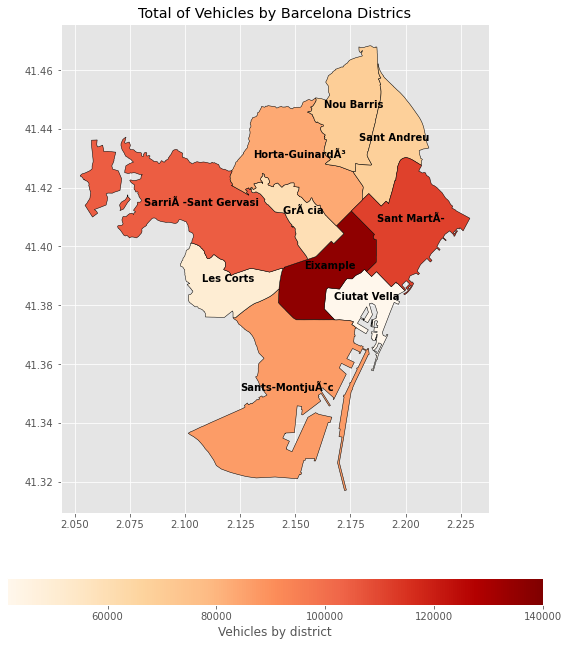

In [414]:
fig, ax = plt.subplots(figsize=(12, 12))

df_bcn_veh.plot('Nombre_vehicles', legend=True, edgecolor='k', 
                ax=ax ,legend_kwds={'label': "Vehicles by district",
                        'orientation': "horizontal", 'shrink':.8, 'pad':.1}, 
                vmax=140e3,cmap="OrRd")  

ax.set_title("Total of Vehicles by Barcelona Districs")

for x, y, labels1  in zip(df_bcn_veh_p.geometry.x,df_bcn_veh_p.geometry.y ,
                          df_bcn_veh_p['n_distri'] ):
        ax.annotate(labels1, xy=(x , y ), xytext=(3, 3), color="k",
                    fontsize=10,
                    weight="bold",
                    textcoords="offset points",
                    horizontalalignment='center'
                    )
plt.show()

The districts with the highest number of vehicles are Eixample, Sant Marti, Sarria-Sant Gervarsi, the least Ciutat Vella, Lest Corts and Gracia.  

In [415]:
#list with the number of veh features
veh_list_cols = df_bcn_veh.columns[13:]
veh_list_cols

Index(['Num_Altres_vehicles', 'Num_Camions', 'Num_Ciclomotors',
       'Num_Furgonetes', 'Num_Motos', 'Num_Turismes'],
      dtype='object')

In [416]:
districts_layer = df_bcn_veh.explore(column= "Nombre_vehicles",
                  tooltip="Nombre_vehicles",
                  popup= True,
                  cmap="OrRd",
                  style_kwds=dict(color="black"),
                                     name = "BCN Districts",
                                      width= 750,height=500,
                                     )

 
districts_layer

The interactive map show barcelona districts the number of vehicles when you click the maps shows the more detailed info of the district. Sarria - Sant Gervasi have a bigger area than Eixample but the former have less urban area, so have more vehicles.       

/Users/franciscoregalado/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


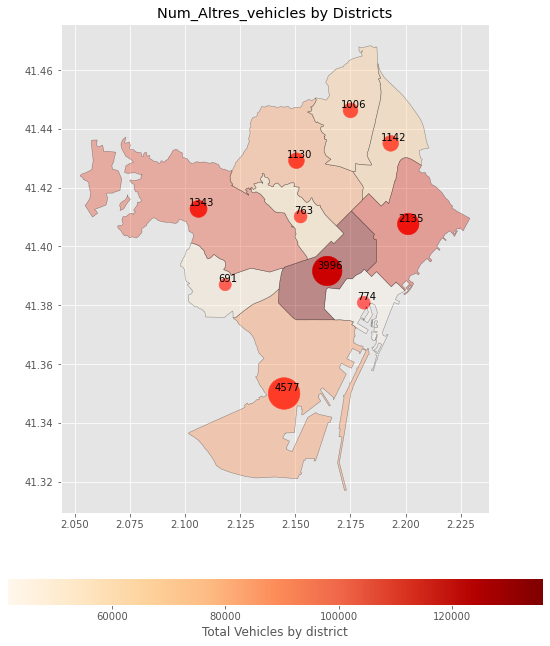

/Users/franciscoregalado/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


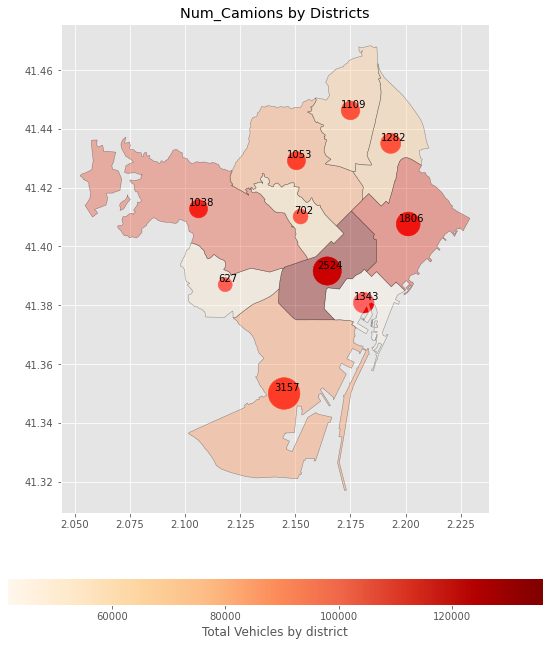

/Users/franciscoregalado/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


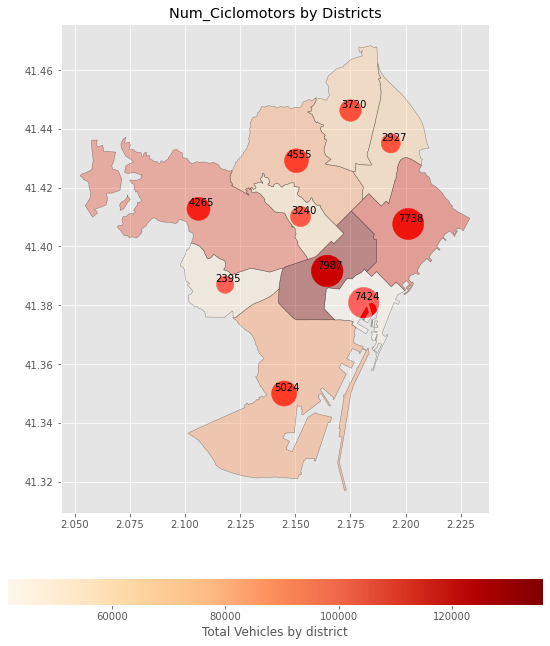

/Users/franciscoregalado/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


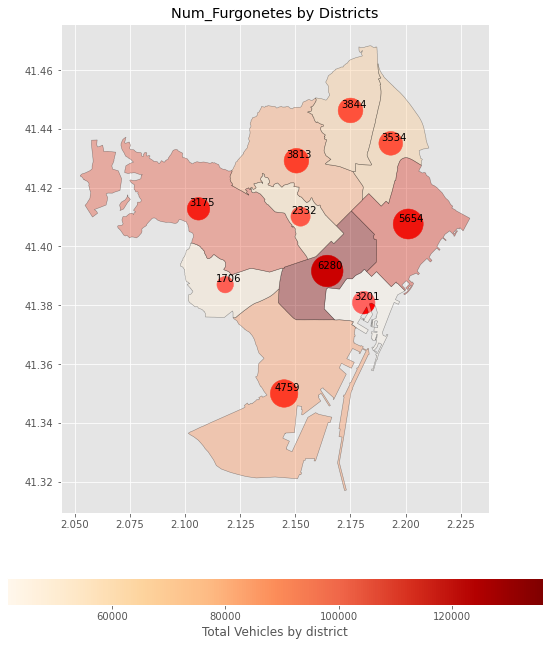

/Users/franciscoregalado/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


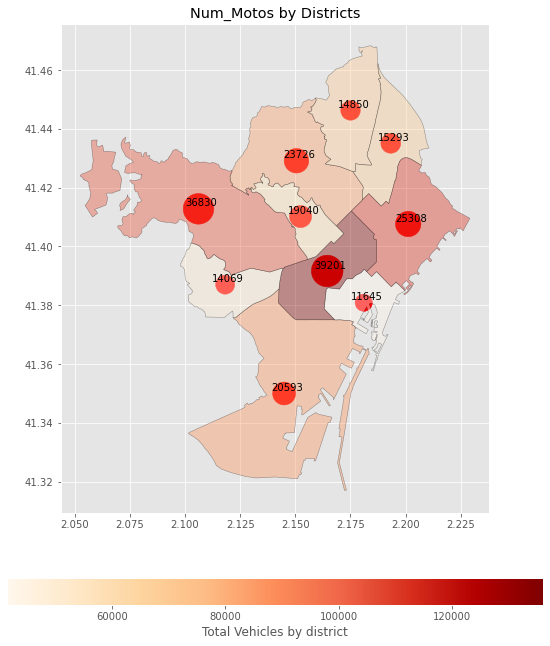

/Users/franciscoregalado/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


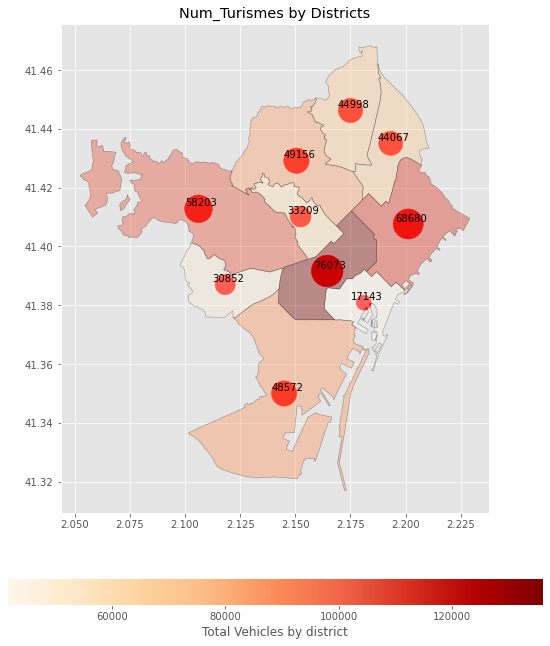

In [417]:
#individual map of number of vehicles by district  
for i,j in zip(veh_list_cols,veh_types):  
    plot_veh(df_bcn_veh_p,df_bcn_veh,i,j,"Nombre_vehicles")

The plot shows the number of vechicles by districts with a point sized by the type number of vehicles, the graphs show a trend toward the use of vehicles in the different districts.

<h3>Preprocessing</h3>

I will drop some features that will not add information for the model as the coordinates or webpages. 

In [418]:
df2 = df.copy()
df2.head()

,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Seccio_censal,Tipologia_parc,Nombre_vehicles
0,2021,01,Ciutat Vella,01,el Raval,1,Turismes,338
1,2021,01,Ciutat Vella,01,el Raval,1,Motos,128
2,2021,01,Ciutat Vella,01,el Raval,1,Ciclomotors,682
3,2021,01,Ciutat Vella,01,el Raval,1,Furgonetes,51
4,2021,01,Ciutat Vella,01,el Raval,1,Camions,23


In [419]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6398 entries, 0 to 6397
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Any              6398 non-null   int64   
 1   Codi_Districte   6398 non-null   object  
 2   Nom_Districte    6398 non-null   category
 3   Codi_Barri       6398 non-null   object  
 4   Nom_Barri        6398 non-null   category
 5   Seccio_censal    6398 non-null   object  
 6   Tipologia_parc   6398 non-null   category
 7   Nombre_vehicles  6398 non-null   int64   
dtypes: category(3), int64(2), object(3)
memory usage: 321.9+ KB


In [420]:
#use function (8) to drop columns
df_veh1 = drop_cols(df2,select_dtype(df2,["object"])) 
df_veh = drop_cols(df_veh1,"Any")
df_veh  

,Nom_Districte,Nom_Barri,Tipologia_parc,Nombre_vehicles
0,Ciutat Vella,el Raval,Turismes,338
1,Ciutat Vella,el Raval,Motos,128
2,Ciutat Vella,el Raval,Ciclomotors,682
3,Ciutat Vella,el Raval,Furgonetes,51
4,Ciutat Vella,el Raval,Camions,23
...,...,...,...,...
6393,Sant Martí,la Verneda i la Pau,Motos,127
6394,Sant Martí,la Verneda i la Pau,Ciclomotors,55
6395,Sant Martí,la Verneda i la Pau,Furgonetes,31
6396,Sant Martí,la Verneda i la Pau,Camions,16


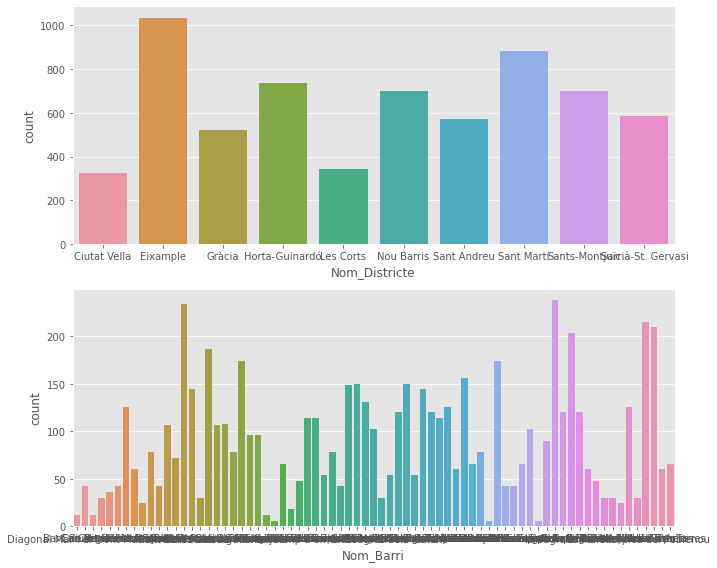

In [421]:
fig , axes = plt.subplots(2,1,figsize=(10,8))
plt.style.use('ggplot')

for i,val in enumerate(select_dtype(df_veh,["category"])[:2]):
    sns.countplot(x=val,data=df_veh,ax=axes[i]) 
    plt.tight_layout()
plt.show()

The plots show us a imbalanced dataset    

In [422]:
df_veh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6398 entries, 0 to 6397
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Nom_Districte    6398 non-null   category
 1   Nom_Barri        6398 non-null   category
 2   Tipologia_parc   6398 non-null   category
 3   Nombre_vehicles  6398 non-null   int64   
dtypes: category(3), int64(1)
memory usage: 380.0 KB


In [423]:
#select the categorical features to encode
objects_to_encoding = df_veh.select_dtypes(include = ["category"]).columns 
objects_to_encoding 

Index(['Nom_Districte', 'Nom_Barri', 'Tipologia_parc'], dtype='object')

In [424]:
#I will use a label encoder to transform the string to a int 
LabelEncoder = preprocessing.LabelEncoder()  

for i in objects_to_encoding:
    df_veh[i] = LabelEncoder.fit_transform(df_veh[i]) 

In [425]:
df_veh 

,Nom_Districte,Nom_Barri,Tipologia_parc,Nombre_vehicles
0,0,45,5,338
1,0,45,4,128
2,0,45,2,682
3,0,45,3,51
4,0,45,1,23
...,...,...,...,...
6393,7,67,4,127
6394,7,67,2,55
6395,7,67,3,31
6396,7,67,1,16


<h3>Exercise 1</h3>

**Gather the set of data you use and perform a pipeline and a gridsearch applying the Random Forest algorithm.**

In [426]:
#The dataset if imbalanced so I will use a smote to balanced it
 
smote = SMOTE(random_state=7,sampling_strategy='not majority')
under = RandomUnderSampler(sampling_strategy='not majority')
rf = RandomForestClassifier()

In [427]:
 # Hyperparameter Tuning
parameters = {
    'rf__n_estimators': [10,100, 200], 
    'rf__max_depth' : [2, 4, 6, 8, 10],
    'rf__min_samples_split': [12,20,40],
    'rf__criterion':['gini', 'entropy'],
    'rf__bootstrap': [True, False]
}

In [428]:
#define my X and y
X= df_veh.drop(["Tipologia_parc"], axis=1)
y = df_veh["Tipologia_parc"]
X.head()

,Nom_Districte,Nom_Barri,Nombre_vehicles
0,0,45,338
1,0,45,128
2,0,45,682
3,0,45,51
4,0,45,23


In [429]:
# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size= 0.2, 
                                                    random_state=7,
                                                   shuffle = True)

In [430]:
 # Shape of split
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((5118, 3), (5118,), (1280, 3), (1280,))

In [431]:
#make the pipeline
pipeline =   Pipeline([     
                     ('smote', smote),
                     ('under',under),
                     ('rf', rf) 
    
])
    

In [432]:
set_config(display='diagram')

pipeline

#the figure show the structure of the pipeline 

Pipeline(steps=[('smote',
                 SMOTE(random_state=7, sampling_strategy='not majority')),
                ('under', RandomUnderSampler(sampling_strategy='not majority')),
                ('rf', RandomForestClassifier())])

In [433]:
skfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

In [451]:
grid = GridSearchCV(pipeline, parameters,cv=skfold)

In [474]:
y_score = grid.fit(X_train, y_train) 

In [462]:
grid.best_score_

0.6129347401328644

The best score of rhe GridSearch tells us that the models with <br> the best parameters have a fit of 61.29%. 

In [455]:
#best parameters
grid.best_params_

{'rf__bootstrap': True,
 'rf__criterion': 'entropy',
 'rf__max_depth': 10,
 'rf__min_samples_split': 12,
 'rf__n_estimators': 200}

In [454]:
y_pred = grid.predict(X_test) 

In [457]:
classes_names = data.Tipologia_parc.unique()
classes_lista = pd.Series(classes_names).sort_values(ascending=True).to_list()  
classes_lista

['Altres vehicles',
 'Camions',
 'Ciclomotors',
 'Furgonetes',
 'Motos',
 'Turismes']

In [458]:
report_rf = classification_report(y_test , y_pred,output_dict=True ,target_names=classes_lista)
df_report_rf = pd.DataFrame(report_rf).T 
df_report_rf

,precision,recall,f1-score,support
Altres vehicles,0.474886,0.456140,0.465324,228.0000
Camions,0.480663,0.424390,0.450777,205.0000
Ciclomotors,0.455556,0.600000,0.517895,205.0000
Furgonetes,0.348101,0.279188,0.309859,197.0000
Motos,0.933333,0.907407,0.920188,216.0000
Turismes,0.904959,0.956332,0.929936,229.0000
accuracy,0.612500,0.612500,0.612500,0.6125
macro avg,0.599583,0.603910,0.598997,1280.0000
weighted avg,0.607508,0.612500,0.607367,1280.0000


The report of the different vehicle types shows that the model predicts <br> better the Tourism and Bikes and drops sharply for the rest of vehicles.  

In [459]:
#confusion matrix for each veh type
matrix_multi = multilabel_confusion_matrix(y_test, y_pred )
matrix_multi

array([[[ 937,  115],
        [ 124,  104]],

       [[ 981,   94],
        [ 118,   87]],

       [[ 928,  147],
        [  82,  123]],

       [[ 980,  103],
        [ 142,   55]],

       [[1050,   14],
        [  20,  196]],

       [[1028,   23],
        [  10,  219]]])

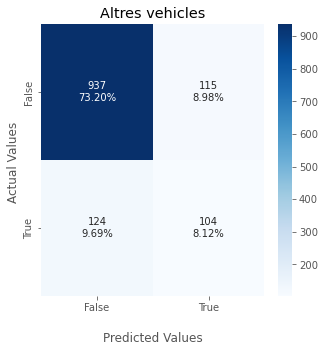

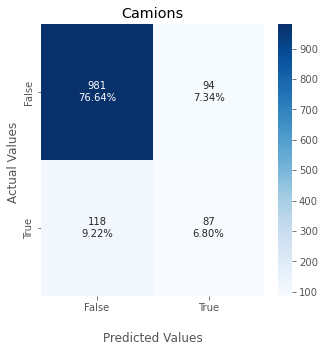

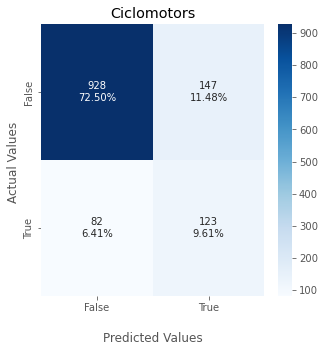

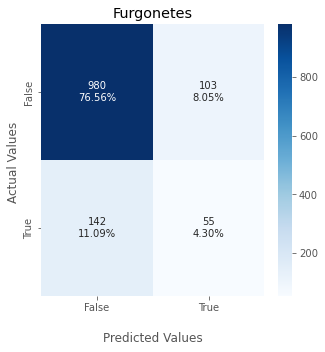

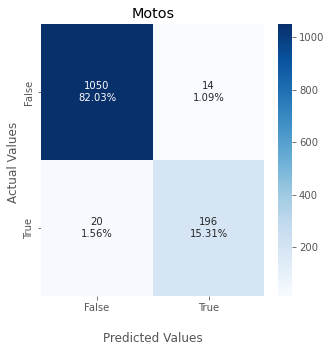

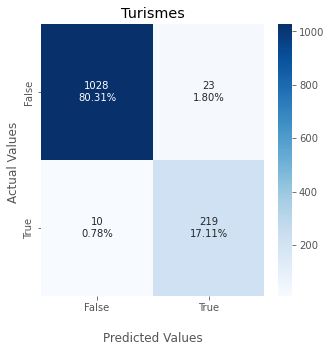

In [460]:
#use the function (9) to plot each class
for matrix,title in zip(matrix_multi,classes_lista): 
    plot_conf_matrix(matrix,title)

The confusion matrix plots show what the classification report shows the low <br>
number of false positive of tourism and bikes.  

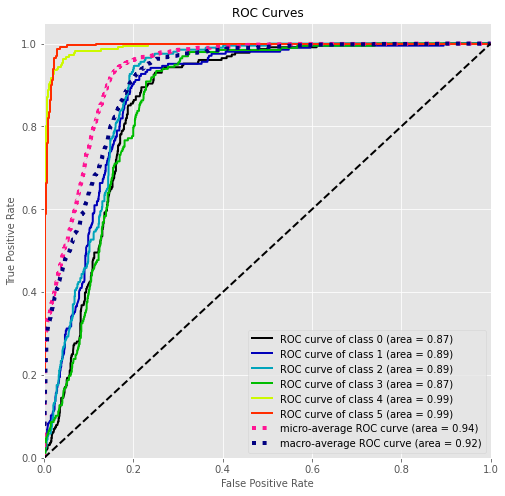

In [493]:
grid.predict_proba(X_test)    
skplt.metrics.plot_roc(y_test, y_probas,title='ROC Curves',figsize=(8,8),)
plt.show()

The ROC curve shows that the Random Forest Classifier doesn't model well the data,<br> it can model very well only 2 classes, in general the model can be used <br> but its important to know which classes are have a better fit.  

 <h3>Exercise 2</h3>

 **Take a text in English that you want, and calculate the frequency of the words**

In [73]:
raw_text = "Fragments Within the Works of Tolkien When writing The Lord of the Rings, Tolkien strove to build a mythos of England. To do so, Tolkien drew from the fragments in the world around him. Over the course of the past two weeks, we have used our understanding of Tolkien’s fascination with the fragments in our world to better understand where Tolkien’s stories come from; however, The Notion Club Papers have demonstrated to me that we have neglected to consider how the idea of “fragments” has affected the telling of the stories themselves. The Notion Club Papers provide a glimpse of Tolkien’s creating process in the form of Ramer’s ramblings: The act of Creation is one of finding fragments and giving them context. Looking back now at Tolkien’s stories –The Lord of the Rings­ in particular – I find that fragments lie at their very hearts. Through this examination, I hope to achieve better knowledge of Tolkien’s use of fragments so as to better understand the stories themselves. First, I will prove a brief account of fragments as we understand them. The fragments that Tolkien was most often interested in were those of language – for example, the remaining snippets of a long lost poem or an oddity in a word’s modern meaning. Being the philologist that he was, Tolkien would take these fragments and try to provide a history, a context, for them. Effectively, Tolkien was using these fragments to work backwards through time by developing for the fragment an etymology of sorts. The class identified a clear example of this in Book I of The Lord of the Rings where Frodo sings a full version of “Hey diddle diddle” and establishes it as a song that was old even when Frodo sang it in Bree. By creating a history for the poem, Tolkien creates a tangible connection between the modern day and his Creation. Through examination of Ramer’s ramblings in Tolkien’s Notion Club Papers we can gain insight as to how Tolkien understood and used fragments. In The Notion Club Papers, Ramer expresses the idea that the identity of an object or place is the union of its physical self with its history; fragments preserve this identity even after the subject has lost its physical and historical presence by continuing to tell the story. However, these fragments are meaningless without context, much in the way that a meteorite – a fragment of what was once a large object with a long history – is just another stone if we do not already know its history. Language fragments are unique in this aspect in that the fragment’s history can often be found within the fragment itself. What enables Tolkien to find the story within these fragments is the heredity of language: Human beings have a “native language” which is stored within our “incarnate beings.” By linking modern fragments to the languages that he had been developing since childhood, Tolkien was able to provide a context for the fragments – he was able to move back in time. Interestingly, we can find the motif of fragments within Tolkien’s stories themselves and The Lord of the Rings in particular. The One Ring was a powerful artifact of the Second Age, an object of great power – but when Sauron was cast down and the Ring lost, its context was lost with it. When Bilbo found it an Age later, it was nothing more than a ring with interesting capabilities. The Ring was a mere fragment of its dark master, a fragment of an Age, a fragment without context. Nor does it seem that Bilbo was particularly concerned with the history of the Ring, for he had made no progress as to its identity by the time he had passed it on to Frodo. However, it is only when the Ring is passed on to Frodo that the Ring’s true nature is revealed and Frodo can begin to move towards truly understanding the Ring and its history. Frodo completes the history of the Ring by means of a heredity “native language” of adventure shared between him and Bilbo. And when the Ring is finally destroyed, it takes with it the remnants of the Second Age. In this way I believe that Frodo has a lot in common with Ramer and Tolkien. At the conclusion of The Lord of the Rings, Merry and Pippin and Sam have successfully reintegrated into hobbit society, but not so Frodo. As bearer of the One Ring, Frodo had pursued its story and completed the tale of the Lord of the Rings, but he had also been exposed to its power. I suspect this exposure to be similar in effect to Ramer’s lucid dreams: His dream-wanderings and the pursuit of fragments through time and space have broadened his perspective in a way that other members of the Notion Club seem unable to really identify with, even if they have some experience in setting their own dreams free. Like Ramer, Frodo has experienced the vastness of the world in the sense of time and space, and his experience has marked him. As a result, Frodo is unable in reintegrate into his old life and is ultimately forced to depart. In the above I have attempted to explore the importance of fragments not only as tools of creation but as motifs within the Lord of the Rings. A more complete analysis should give more attention to those stories in which the fragment in question was not given a context outside of the plot, as in The Hobbit or Smith of Wootton Major. I believe it would be interesting to compare elements of both types of stories – those in which context is given to the fragment and those where it is not – to determine how the narrative is affected. Author: N. Malaqai Vasquez"
print(raw_text)

Fragments Within the Works of Tolkien When writing The Lord of the Rings, Tolkien strove to build a mythos of England. To do so, Tolkien drew from the fragments in the world around him. Over the course of the past two weeks, we have used our understanding of Tolkien’s fascination with the fragments in our world to better understand where Tolkien’s stories come from; however, The Notion Club Papers have demonstrated to me that we have neglected to consider how the idea of “fragments” has affected the telling of the stories themselves. The Notion Club Papers provide a glimpse of Tolkien’s creating process in the form of Ramer’s ramblings: The act of Creation is one of finding fragments and giving them context. Looking back now at Tolkien’s stories –The Lord of the Rings­ in particular – I find that fragments lie at their very hearts. Through this examination, I hope to achieve better knowledge of Tolkien’s use of fragments so as to better understand the stories themselves. First, I will 

In [74]:
#remove punctuation from text
translator = str.maketrans('', '', string.punctuation)
clean_text = raw_text.translate(translator)
print(clean_text)

Fragments Within the Works of Tolkien When writing The Lord of the Rings Tolkien strove to build a mythos of England To do so Tolkien drew from the fragments in the world around him Over the course of the past two weeks we have used our understanding of Tolkien’s fascination with the fragments in our world to better understand where Tolkien’s stories come from however The Notion Club Papers have demonstrated to me that we have neglected to consider how the idea of “fragments” has affected the telling of the stories themselves The Notion Club Papers provide a glimpse of Tolkien’s creating process in the form of Ramer’s ramblings The act of Creation is one of finding fragments and giving them context Looking back now at Tolkien’s stories –The Lord of the Rings­ in particular – I find that fragments lie at their very hearts Through this examination I hope to achieve better knowledge of Tolkien’s use of fragments so as to better understand the stories themselves First I will prove a brief 

In [75]:
  # break the text into words
token_word = word_tokenize(clean_text)
print(token_word[23:43])

['so', 'Tolkien', 'drew', 'from', 'the', 'fragments', 'in', 'the', 'world', 'around', 'him', 'Over', 'the', 'course', 'of', 'the', 'past', 'two', 'weeks', 'we']


In [76]:
word_freq = FreqDist(token_word)
word_freq 

FreqDist({'the': 65, 'of': 54, 'to': 28, 'a': 28, 'in': 24, 'and': 21, 'fragments': 20, 'Tolkien': 18, 'is': 14, 'was': 14, ...})

In [77]:
token_text_item = word_freq.items()
print(token_text_item) 

dict_items([('Fragments', 1), ('Within', 1), ('the', 65), ('Works', 1), ('of', 54), ('Tolkien', 18), ('When', 2), ('writing', 1), ('The', 13), ('Lord', 7), ('Rings', 6), ('strove', 1), ('to', 28), ('build', 1), ('a', 28), ('mythos', 1), ('England', 1), ('To', 1), ('do', 2), ('so', 3), ('drew', 1), ('from', 2), ('fragments', 20), ('in', 24), ('world', 3), ('around', 1), ('him', 3), ('Over', 1), ('course', 1), ('past', 1), ('two', 1), ('weeks', 1), ('we', 6), ('have', 8), ('used', 2), ('our', 3), ('understanding', 2), ('’', 13), ('s', 13), ('fascination', 1), ('with', 9), ('better', 3), ('understand', 3), ('where', 3), ('stories', 7), ('come', 1), ('however', 1), ('Notion', 5), ('Club', 5), ('Papers', 4), ('demonstrated', 1), ('me', 1), ('that', 13), ('neglected', 1), ('consider', 1), ('how', 3), ('idea', 2), ('“', 5), ('”', 5), ('has', 5), ('affected', 2), ('telling', 1), ('themselves', 3), ('provide', 3), ('glimpse', 1), ('creating', 2), ('process', 1), ('form', 1), ('Ramer', 6), ('ram

In [78]:
word_freq_df = pd.DataFrame(token_text_item,columns=["Word","Freq"])
word_freq_df

,Word,Freq
0,Fragments,1
1,Within,1
2,the,65
3,Works,1
4,of,54
...,...,...
363,narrative,1
364,Author,1
365,N,1
366,Malaqai,1


In [79]:
token_freq_sorted_df = word_freq_df.nlargest(20,"Freq").sort_values(by="Freq",ascending=False)
token_freq_sorted_df

,Word,Freq
2,the,65
4,of,54
12,to,28
14,a,28
23,in,24
75,and,21
22,fragments,20
5,Tolkien,18
72,is,14
106,was,14


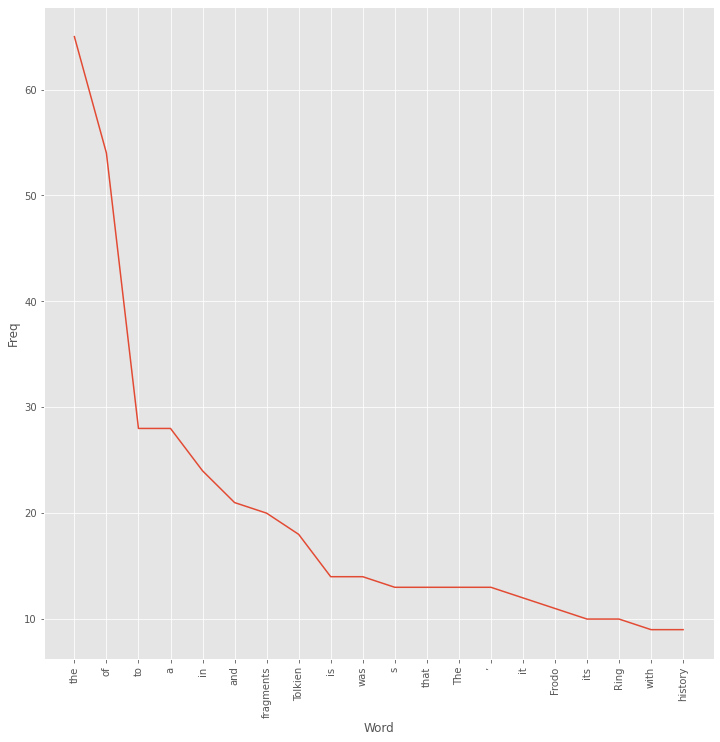

In [80]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(x="Word",y="Freq",data=token_freq_sorted_df)
plt.xticks(rotation=90)
plt.show()

<h2>Level 2</h2>

<h3>Exercici 1</h3>

**Remove stopwords and stemming your dataset.**

In [81]:
#words that need be removed
stop_words=set(stopwords.words("english"))
print(stop_words)

{'itself', 'his', 'am', 'nor', 'its', 'our', 'is', 'was', 'o', 'it', 'about', 'and', 'for', 'myself', "she's", 'off', 'so', 'wasn', 'will', 'mustn', 'above', 'after', 'this', 'such', 'with', 'm', 'ain', 'before', 'or', 'are', "didn't", 'all', "aren't", "mustn't", 'there', 'he', 'why', 'to', 'haven', 'doesn', 'we', 'very', 'shouldn', 'few', 'just', 'can', 'but', 'had', 'over', 'him', 'which', "hasn't", 'each', 'that', 'she', 'once', 'their', "isn't", 'of', 'being', 'in', 'her', "haven't", 'the', 'hadn', 'these', 'if', 'between', 'most', "doesn't", 'll', 'having', 'out', 'shan', 'against', 'mightn', "weren't", 'until', 'own', 'herself', 'below', 'hers', 'whom', 'has', 'doing', 'were', "you'll", 'at', 'here', 'any', 'where', 'while', 'your', 'be', 'from', 'how', 'won', 'themselves', 'needn', 'then', "wasn't", "don't", 'ours', "wouldn't", 'under', 'did', 'both', 'does', 's', 'been', "you're", 'them', 'i', 'isn', "shouldn't", 'on', 're', 'further', 'you', 'weren', 't', 'into', 'same', "won'

In [82]:
#filtered text
filtered_text=[]

for word in token_word:
    if word not in stop_words:
        filtered_text.append(word)

In [83]:
print(filtered_text)

['Fragments', 'Within', 'Works', 'Tolkien', 'When', 'writing', 'The', 'Lord', 'Rings', 'Tolkien', 'strove', 'build', 'mythos', 'England', 'To', 'Tolkien', 'drew', 'fragments', 'world', 'around', 'Over', 'course', 'past', 'two', 'weeks', 'used', 'understanding', 'Tolkien', '’', 'fascination', 'fragments', 'world', 'better', 'understand', 'Tolkien', '’', 'stories', 'come', 'however', 'The', 'Notion', 'Club', 'Papers', 'demonstrated', 'neglected', 'consider', 'idea', '“', 'fragments', '”', 'affected', 'telling', 'stories', 'The', 'Notion', 'Club', 'Papers', 'provide', 'glimpse', 'Tolkien', '’', 'creating', 'process', 'form', 'Ramer', '’', 'ramblings', 'The', 'act', 'Creation', 'one', 'finding', 'fragments', 'giving', 'context', 'Looking', 'back', 'Tolkien', '’', 'stories', '–The', 'Lord', 'Rings\xad', 'particular', '–', 'I', 'find', 'fragments', 'lie', 'hearts', 'Through', 'examination', 'I', 'hope', 'achieve', 'better', 'knowledge', 'Tolkien', '’', 'use', 'fragments', 'better', 'understa

In [84]:
#right now we can see the freq of the words without the noisy words

fdist_filtered = FreqDist(filtered_text)
print(fdist_filtered.most_common(20))

[('fragments', 20), ('Tolkien', 18), ('The', 13), ('’', 13), ('Frodo', 11), ('Ring', 10), ('history', 9), ('fragment', 9), ('context', 8), ('–', 8), ('I', 8), ('Lord', 7), ('stories', 7), ('Rings', 6), ('Ramer', 6), ('Notion', 5), ('Club', 5), ('“', 5), ('”', 5), ('time', 5)]


In [85]:
ps = PorterStemmer()

stemmed_words=[]

for words in filtered_text:
    stemmed_words.append(ps.stem(words))

In [86]:
print(stemmed_words)

['fragment', 'within', 'work', 'tolkien', 'when', 'write', 'the', 'lord', 'ring', 'tolkien', 'strove', 'build', 'mytho', 'england', 'to', 'tolkien', 'drew', 'fragment', 'world', 'around', 'over', 'cours', 'past', 'two', 'week', 'use', 'understand', 'tolkien', '’', 'fascin', 'fragment', 'world', 'better', 'understand', 'tolkien', '’', 'stori', 'come', 'howev', 'the', 'notion', 'club', 'paper', 'demonstr', 'neglect', 'consid', 'idea', '“', 'fragment', '”', 'affect', 'tell', 'stori', 'the', 'notion', 'club', 'paper', 'provid', 'glimps', 'tolkien', '’', 'creat', 'process', 'form', 'ramer', '’', 'rambl', 'the', 'act', 'creation', 'one', 'find', 'fragment', 'give', 'context', 'look', 'back', 'tolkien', '’', 'stori', '–the', 'lord', 'rings\xad', 'particular', '–', 'i', 'find', 'fragment', 'lie', 'heart', 'through', 'examin', 'i', 'hope', 'achiev', 'better', 'knowledg', 'tolkien', '’', 'use', 'fragment', 'better', 'understand', 'stori', 'first', 'i', 'prove', 'brief', 'account', 'fragment', 'u

In [87]:
word_freq_stemmed = FreqDist(stemmed_words)
word_freq_stemmed  

FreqDist({'fragment': 30, 'tolkien': 18, 'ring': 17, 'the': 13, '’': 13, 'frodo': 11, 'stori': 10, 'histori': 9, 'context': 8, '–': 8, ...})

In [88]:
token_text_item_stemmed = word_freq_stemmed.items()
print(token_text_item_stemmed) 

dict_items([('fragment', 30), ('within', 6), ('work', 2), ('tolkien', 18), ('when', 2), ('write', 1), ('the', 13), ('lord', 7), ('ring', 17), ('strove', 1), ('build', 1), ('mytho', 1), ('england', 1), ('to', 1), ('drew', 1), ('world', 3), ('around', 1), ('over', 1), ('cours', 1), ('past', 1), ('two', 1), ('week', 1), ('use', 4), ('understand', 5), ('’', 13), ('fascin', 1), ('better', 3), ('stori', 10), ('come', 1), ('howev', 3), ('notion', 5), ('club', 5), ('paper', 4), ('demonstr', 1), ('neglect', 1), ('consid', 1), ('idea', 2), ('“', 5), ('”', 5), ('affect', 2), ('tell', 2), ('provid', 3), ('glimps', 1), ('creat', 3), ('process', 1), ('form', 1), ('ramer', 6), ('rambl', 2), ('act', 1), ('creation', 3), ('one', 3), ('find', 4), ('give', 2), ('context', 8), ('look', 1), ('back', 2), ('–the', 1), ('rings\xad', 1), ('particular', 2), ('–', 8), ('i', 8), ('lie', 1), ('heart', 1), ('through', 2), ('examin', 2), ('hope', 1), ('achiev', 1), ('knowledg', 1), ('first', 1), ('prove', 1), ('brie

In [89]:
word_freq_stemmed_df = pd.DataFrame(token_text_item_stemmed,columns=["Word","Freq"])
word_freq_stemmed_df.head()

,Word,Freq
0,fragment,30
1,within,6
2,work,2
3,tolkien,18
4,when,2


In [90]:
stemmed_freq_sorted_df = word_freq_stemmed_df.nlargest(20,"Freq").sort_values(by="Freq",ascending=False)
stemmed_freq_sorted_df.head()

,Word,Freq
0,fragment,30
3,tolkien,18
8,ring,17
6,the,13
24,’,13


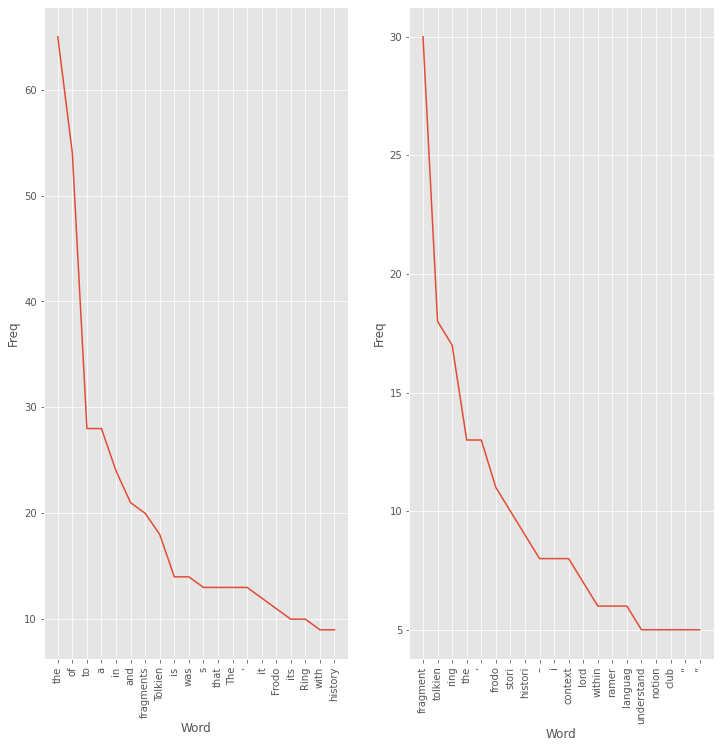

In [91]:
fig, axes = plt.subplots(1,2,figsize=(12, 12))
sns.lineplot(x="Word",y="Freq",data=token_freq_sorted_df,ax=axes[0])
sns.lineplot(x="Word",y="Freq",data=stemmed_freq_sorted_df,ax=axes[1])
axes[0].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='x', rotation=90)
plt.show()

The stemmed text shows better the repeated words, the tokenized text have a lot of prepositions and articles.

<h2>Level 3</h2>

<h3>Exercici 1</h3>

**Perform sentiment analysis on your dataset.**

In [92]:
tokenized_text =sent_tokenize(raw_text)
print(tokenized_text)

['Fragments Within the Works of Tolkien When writing The Lord of the Rings, Tolkien strove to build a mythos of England.', 'To do so, Tolkien drew from the fragments in the world around him.', 'Over the course of the past two weeks, we have used our understanding of Tolkien’s fascination with the fragments in our world to better understand where Tolkien’s stories come from; however, The Notion Club Papers have demonstrated to me that we have neglected to consider how the idea of “fragments” has affected the telling of the stories themselves.', 'The Notion Club Papers provide a glimpse of Tolkien’s creating process in the form of Ramer’s ramblings: The act of Creation is one of finding fragments and giving them context.', 'Looking back now at Tolkien’s stories –The Lord of the Rings\xad in particular – I find that fragments lie at their very hearts.', 'Through this examination, I hope to achieve better knowledge of Tolkien’s use of fragments so as to better understand the stories themse

In [94]:
df_text = pd.DataFrame({'lines': tokenized_text})
df_text.head()

,lines
0,Fragments Within the Works of Tolkien When wri...
1,"To do so, Tolkien drew from the fragments in t..."
2,"Over the course of the past two weeks, we have..."
3,The Notion Club Papers provide a glimpse of To...
4,Looking back now at Tolkien’s stories –The Lor...


In [96]:
sentiment_analyzer = SentimentIntensityAnalyzer()

sentiments = df_text['lines'].apply(lambda x: sentiment_analyzer.polarity_scores(x))

df_text['compound'] = sentiments.apply(lambda x : x['compound'])
df_text['negative'] = sentiments.apply(lambda x : x['neg'])
df_text['neutral'] = sentiments.apply(lambda x : x['neu'])
df_text['positive'] = sentiments.apply(lambda x : x['pos'])

In [106]:
df_text.head()

,lines,compound,negative,neutral,positive
0,Fragments Within the Works of Tolkien When wri...,0.0000,0.000,1.000,0.000
1,"To do so, Tolkien drew from the fragments in t...",0.0000,0.000,1.000,0.000
2,"Over the course of the past two weeks, we have...",0.2732,0.077,0.829,0.094
3,The Notion Club Papers provide a glimpse of To...,0.6908,0.000,0.795,0.205
4,Looking back now at Tolkien’s stories –The Lor...,0.0000,0.000,1.000,0.000


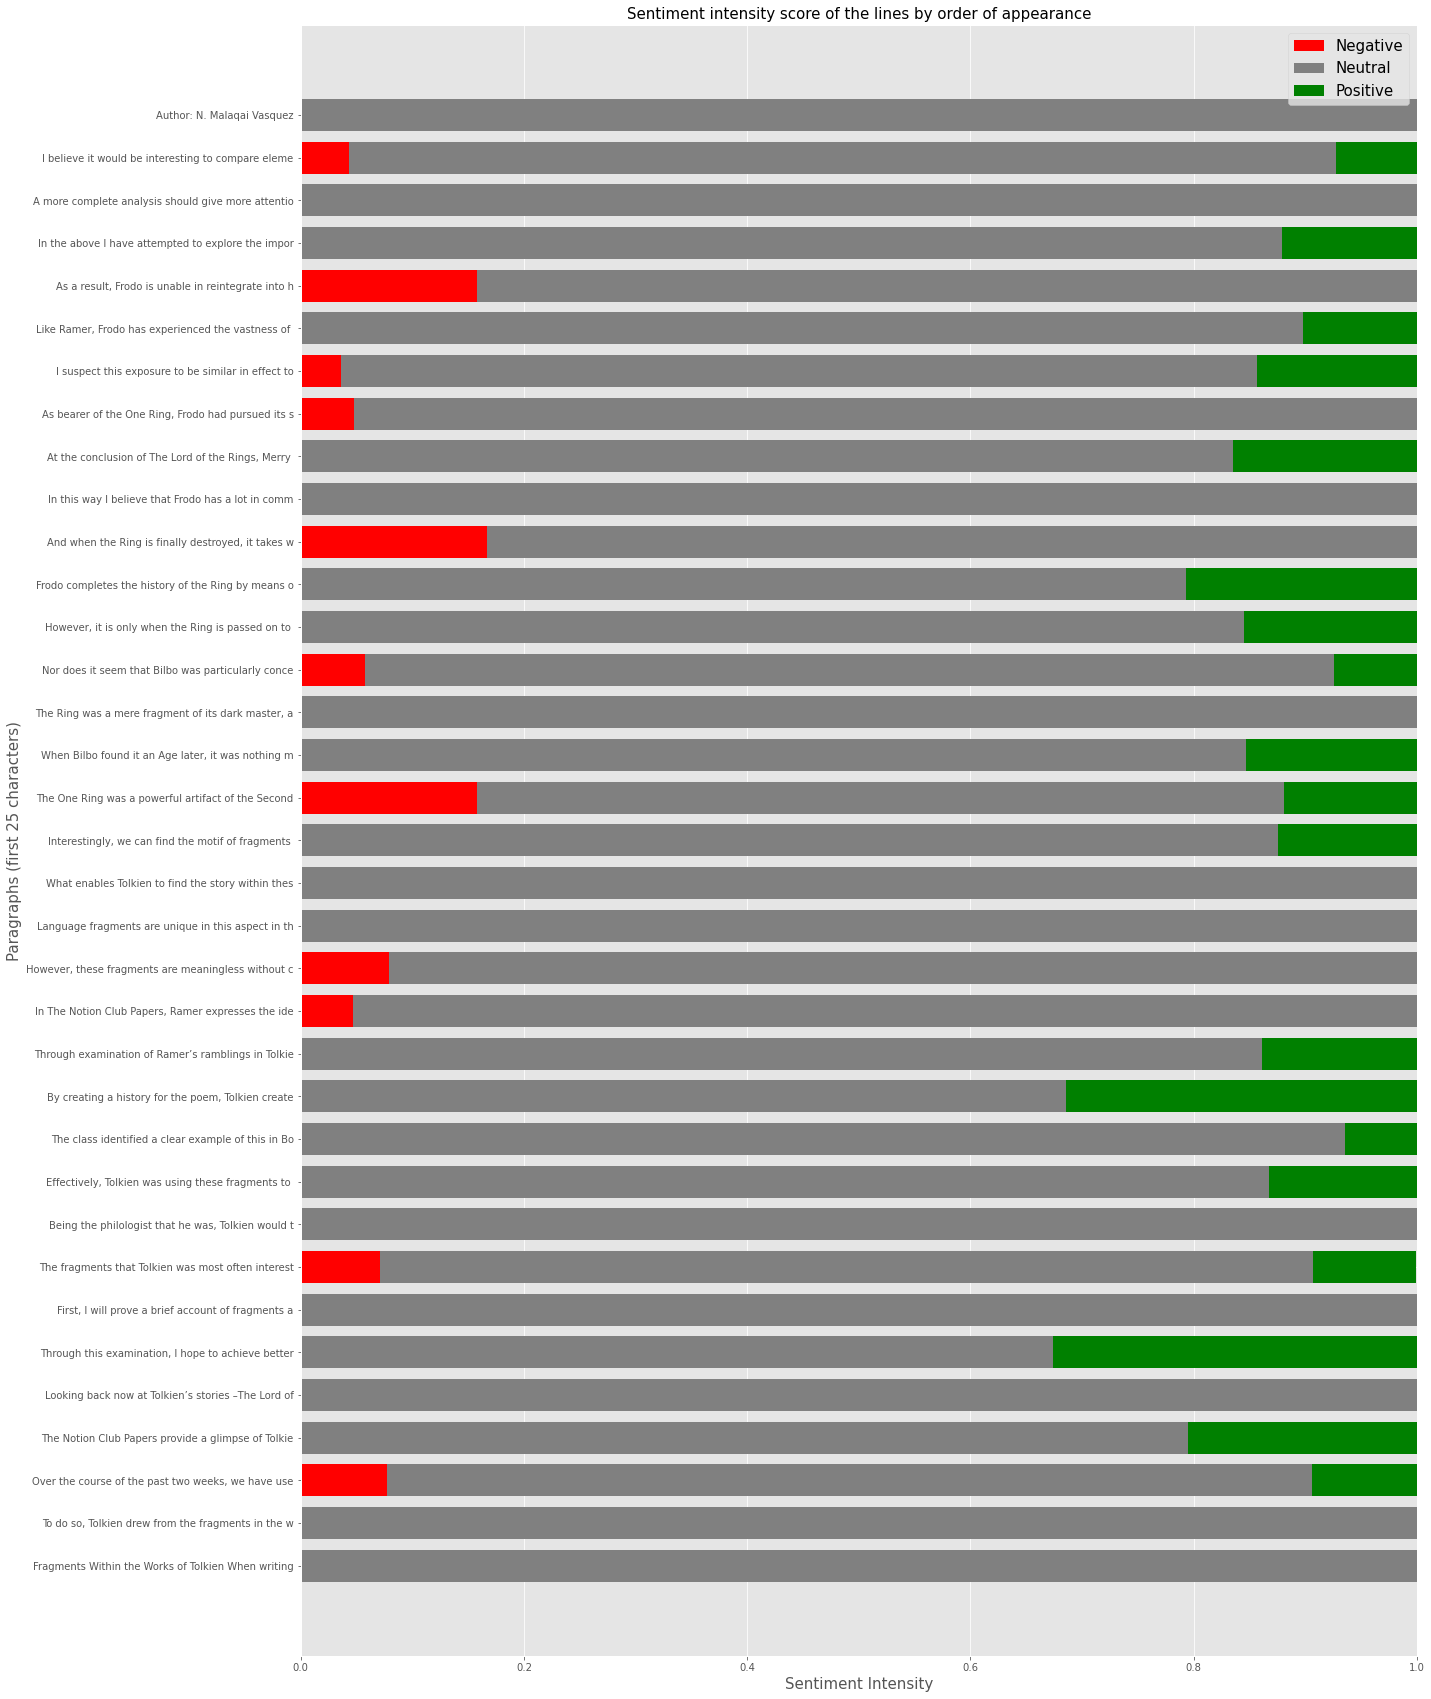

In [109]:
plt.figure(figsize=(20,30))

names = df_text['lines'].str[:50]

barWidth = 0.75

# Create negative Bars
plt.barh(y=names, 
        width=df_text.negative, 
        height=barWidth, color='red', label='Negative')
# Create neutral Bars
plt.barh(y=names, 
        width=df_text.neutral,
        height=barWidth,  left=df_text.negative,  color='gray', label='Neutral')
# Create positive Bars
plt.barh(y=names, 
        width=df_text.positive, 
        height=barWidth,  left=[i+j for i,j in zip(df_text.negative, df_text.neutral)],color='green', label='Positive')
 
plt.yticks(names)
plt.ylabel("Paragraphs (first 25 characters)", fontsize=15)
plt.xlabel("Sentiment Intensity", fontsize=15)
plt.legend(fontsize=15) 
plt.title("Sentiment intensity score of the lines by order of appearance", fontsize=15)

plt.show()



The sentiment analysis shows that the text is almost neutral, obviously the author is a Tolkien fan and the article is about the universe of the LOTR.